# Libraries

In [1]:
import cv2
import matplotlib.pyplot as plt

# Load Images

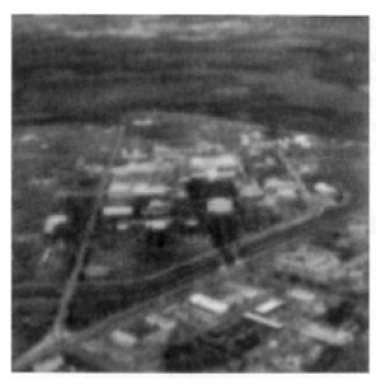

In [3]:
img1 = cv2.imread('Fig5.25.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(img1, cmap='gray')
plt.axis('off')
plt.show()

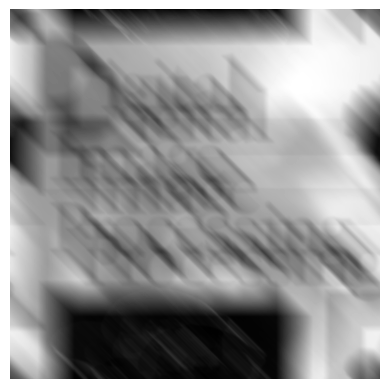

In [4]:
img2 = cv2.imread('book-cover-blurred.tif', cv2.IMREAD_GRAYSCALE)
plt.imshow(img2, cmap='gray')
plt.axis('off')
plt.show()